<a href="https://colab.research.google.com/github/justin-hsieh/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [0]:
import random
dir(random)  # Reminding ourselves what we can do here

In [0]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple # generate individuals separately and put them into a list more easily
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

In [17]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(2500): #fewer desktop users than mobile users
  # Desktop users
  time_on_site = random.uniform(10, 600)# generate random time 
  purchased = random.random() < 0.1 + (time_on_site / 1500) #generate random number/probability and add for each second on site
  users.append(User(purchased, time_on_site, False)) #append stats to users series
  
for _ in range(7500):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users) # shuffles the users between mobile and desktop users
print(users[:10]) 

# list of tuples is useful because they can be passed to dataframe easily, refer to below

[User(purchased=True, time_on_site=131.657844146076, mobile=True), User(purchased=True, time_on_site=205.40948706644124, mobile=True), User(purchased=False, time_on_site=82.80763785376888, mobile=True), User(purchased=False, time_on_site=161.72694353416063, mobile=True), User(purchased=True, time_on_site=158.31468757452313, mobile=True), User(purchased=False, time_on_site=237.01459604190404, mobile=False), User(purchased=False, time_on_site=370.8973494930306, mobile=False), User(purchased=False, time_on_site=89.17634966463763, mobile=True), User(purchased=False, time_on_site=12.217091761639328, mobile=True), User(purchased=False, time_on_site=80.81690468010167, mobile=False)]


In [0]:
!pip freeze # current versions of libraries in the environment

In [0]:
!pip install pandas==0.23.4 # installs a previus version of pandas

In [0]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

In [0]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site']) # makes a different table

In [0]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 6)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins) #makes it easier to view the data where it's not so long

In [23]:
# We can make this a bit clearer by normalizing (getting % based on the column)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(4.436, 104.17]","(104.17, 203.31]","(203.31, 302.449]","(302.449, 401.588]","(401.588, 500.728]","(500.728, 599.867]"
purchased,,,,,,
False,0.684372,0.624501,0.576951,0.652278,0.617225,0.562791
True,0.315628,0.375499,0.423049,0.347722,0.382775,0.437209


In [24]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases
#After running the random generator a few times, the data is susceptible to large changes, need a larger sample size to mininmize the effect

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.7048,0.601067
True,0.2952,0.398933


In [45]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

pd.crosstab(user_data['mobile'], [user_data['purchased'], time_bins], normalize ='index')

purchased              False        ...                      True 
time_on_site (4.436, 104.17]        ...         (500.728, 599.867]
mobile                              ...                           
False               0.144800        ...                     0.0752
True                0.219733        ...                     0.0000

[2 rows x 12 columns]

In [0]:
pp = pd.crosstab(user_data['mobile'], [user_data['purchased'], time_bins], normalize ='index')

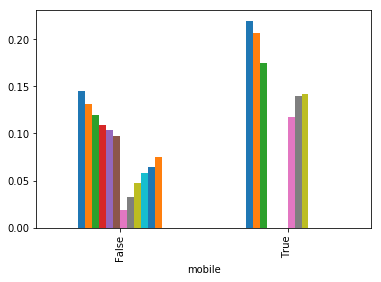

In [34]:
pp.plot(kind='bar', legend =False);

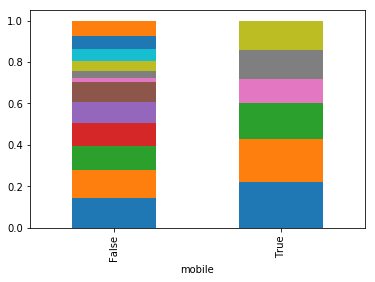

In [35]:
pp.plot(kind='bar', stacked =True, legend =False);

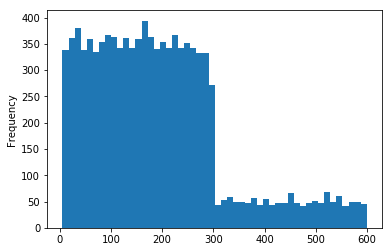

In [37]:
user_data['time_on_site'].plot.hist(bins=50);

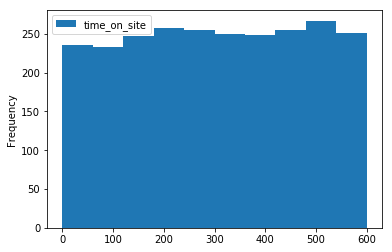

In [43]:
user_data[user_data['mobile']==False].plot.hist();

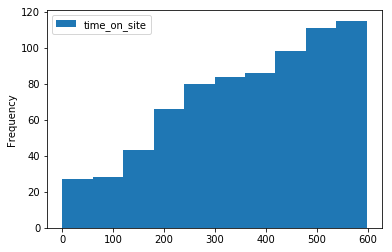

In [48]:
user_data[(user_data['mobile']==False) & (user_data['purchased']==True)].plot.hist()

In [49]:
pt = pd.pivot_table(user_data, values='purchased',index=time_bins)
pt

,purchased
time_on_site,
"(4.436, 104.17]",0.315628
"(104.17, 203.31]",0.375499
"(203.31, 302.449]",0.423049
"(302.449, 401.588]",0.347722
"(401.588, 500.728]",0.382775
"(500.728, 599.867]",0.437209


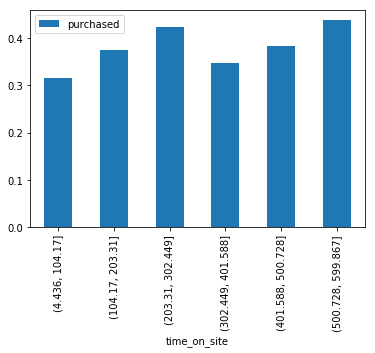

In [51]:
pt.plot.bar();

In [59]:
ct = pd.crosstab(time_bins, [user_data['purchased'],user_data['mobile']], 
                 normalize='columns')
ct

purchased              False               True           
mobile                 False     True      False     True 
time_on_site                                              
(4.436, 104.17]     0.205448  0.365572  0.062331  0.294452
(104.17, 203.31]    0.186720  0.343168  0.109756  0.349933
(203.31, 302.449]   0.169694  0.291260  0.159892  0.355615
(302.449, 401.588]  0.154370  0.000000  0.196477  0.000000
(401.588, 500.728]  0.146425  0.000000  0.216802  0.000000
(500.728, 599.867]  0.137344  0.000000  0.254743  0.000000

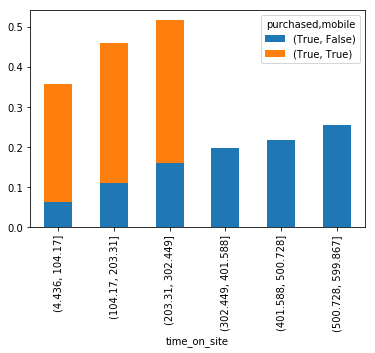

In [60]:
ct_sliced = ct.iloc[:,[2,3]]
ct_sliced.plot(kind='bar', stacked=True)

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [0]:
!pip install pandas==0.23.4 # installs a previus version of pandas

In [0]:
import matplotlib.pyplot as plt

In [71]:

data = pd.read_csv('https://raw.githubusercontent.com/LambdaSchool/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module3-databackedassertions/persons.csv', index_col=0)
data.head()



,age,weight,exercise_time
0,44,118,192
1,41,161,35
2,46,128,220
3,39,216,57
4,28,116,182


In [124]:
age_bins = pd.cut(data['age'], 4)
weight_bins = pd.cut(data['weight'], 6)
exercise_bins = pd.cut(data['exercise_time'],5)

wa = pd.crosstab(weight_bins, age_bins, normalize='columns')
wa

age,"(17.938, 33.5]","(33.5, 49.0]","(49.0, 64.5]","(64.5, 80.0]"
weight,,,,
"(99.854, 124.333]",0.277259,0.281967,0.239130,0.177852
"(124.333, 148.667]",0.258567,0.285246,0.271739,0.197987
"(148.667, 173.0]",0.236760,0.180328,0.188406,0.234899
"(173.0, 197.333]",0.115265,0.118033,0.155797,0.174497
"(197.333, 221.667]",0.090343,0.111475,0.126812,0.147651
"(221.667, 246.0]",0.021807,0.022951,0.018116,0.067114


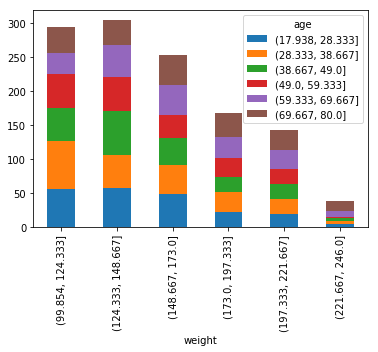

In [121]:
wa.plot(kind='bar', stacked =True); # This plot groups the people in each age group based on each weight group

In [0]:
data.plot.scatter('age', 'exercise_time');

In [0]:
data.plot.scatter('weight', 'exercise_time');

In [114]:
awe = pd.crosstab([age_bins, weight_bins], exercise_bins)
awe

exercise_time                        (-0.3, 60.0]       ...        (240.0, 300.0]
age              weight                                 ...                      
(17.938, 28.333] (99.854, 124.333]              6       ...                    19
                 (124.333, 148.667]             5       ...                    13
                 (148.667, 173.0]               2       ...                     4
                 (173.0, 197.333]               9       ...                     0
                 (197.333, 221.667]            10       ...                     0
                 (221.667, 246.0]               5       ...                     0
(28.333, 38.667] (99.854, 124.333]              9       ...                    16
                 (124.333, 148.667]             8       ...                    18
                 (148.667, 173.0]              11       ...                     8
                 (173.0, 197.333]               8       ...                     0
                 (197.333, 221.667]            13       ...                     0
                 (221.667, 246.0]               4       ...                     0
(38.667, 49.0]   (99.854, 124.333]              3       ...                    23
                 (124.333, 148.667]             7       ...                    25
                 (148.667, 173.0]               5       ...                     9
                 (173.0, 197.333]               7       ...                     0
                 (197.333, 221.667]             9       ...                     0
                 (221.667, 246.0]               5       ...                     0
(49.0, 59.333]   (99.854, 124.333]              7       ...                    19
                 (124.333, 148.667]             2       ...                    26
                 (148.667, 173.0]               4       ...                     4
                 (173.0, 197.333]               9       ...                     0
                 (197.333, 221.667]             6       ...                     0
                 (221.667, 246.0]               1       ...                     0
(59.333, 69.667] (99.854, 124.333]              5       ...                     1
                 (124.333, 148.667]             5       ...                     4
                 (148.667, 173.0]               7       ...                     2
                 (173.0, 197.333]               7       ...                     0
                 (197.333, 221.667]            13       ...                     0
                 (221.667, 246.0]               9       ...                     0
(69.667, 80.0]   (99.854, 124.333]             13       ...                     0
                 (124.333, 148.667]            15       ...                     0
                 (148.667, 173.0]              14       ...                     0
                 (173.0, 197.333]              12       ...                     0
                 (197.333, 221.667]            12       ...                     0
                 (221.667, 246.0]              11       ...                     0

[36 rows x 5 columns]

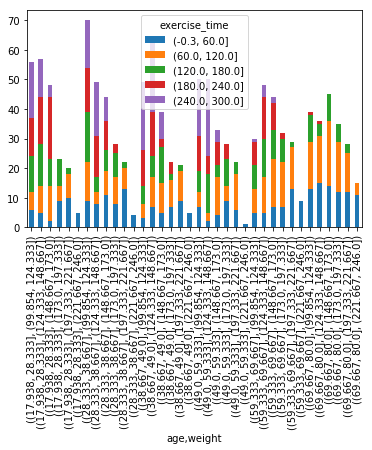

In [110]:
awe.plot(kind='bar', stacked=True);

In [0]:
from mpl_toolkits import mplot3d
import seaborn as sns
import matplotlib.pyplot as plt

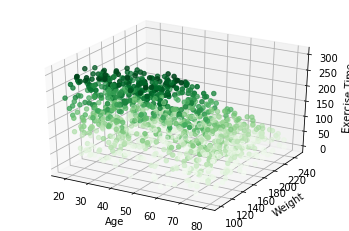

In [106]:
# 3D scatter plot of the three columns

fig = plt.figure()
ax = plt.axes(projection='3d')

x_column = data['age']
y_column = data['weight']
z_column = data['exercise_time']
ax.set_xlabel('Age')
ax.set_ylabel('Weight')
ax.set_zlabel('Exercise Time')
ax.scatter3D(x_column, y_column, z_column, c=z_column, cmap='Greens');


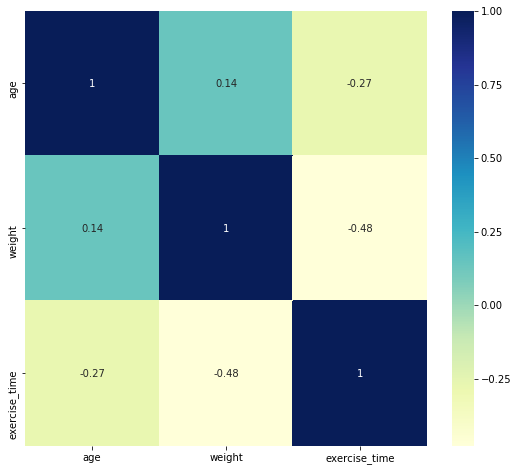

In [140]:
corre = data.corr()
f, ax = plt.subplots(figsize=(9,8))
sns.heatmap(corre, ax=ax, cmap ='YlGnBu', annot =True);


### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
2.  What are the relationships between the variables?
3.  Which relationships are "real", and which spurious?


1.  


Age: Discrete, Ordinal

Weight: Discrete, Ordinal

Exercise time: Discrete Ordinal

All of these values could be considered continuous if measured with more accuracy


---



2. 
Age and weight are positively correlate, although it is a weak one. Age and weight are both negatively correlated with exercise time, but the age and exercise time correlation is not as strong as the weight and exercise time correlation. 



---



3. 
I think the only relationship that could be considered spurious would be age and weight. The other two relationships are real.


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)